In [13]:
from hrr import hrri, convolve, LTM
import numpy as np
import random
import time
import math
import matplotlib
import matplotlib.pyplot as plt

from agent import *
from rl import *
from utils import display_progress

In [36]:
class MazeAgent(RlAgent):
    
    def __init__(self, rl, mazeSize, goal):
        super(MazeAgent, self).__init__(rl)
        self.__size = mazeSize
        self.__goal = goal
        self.__nStates = np.zeros(mazeSize)
        
    def onBegin(self, state, startState = None):
        if startState() is not None:
            state(startState)
        else:
            state(random.randrange(self.__size))
        
    def onStep(self, state):
        self.__nStates[state()] += 1
        if state() == self.__goal and self.stepCount() != 0:
            return False
        action = self.predict(f"s{state()}", ("left", "right"), epsilon=1/math.sqrt(self.__nStates[state()]))
        if action == 0:
            state((state() - 1) % self.__size)
        else:
            state((state() + 1) % self.__size)
    
    def onFinish(self, state):
        if state() == self.__goal:
            self.reward(1.0)
        return self.stepCount()

In [27]:
# Hard limit number of moves for a single episode
STEP_LIMIT = 100

In [37]:
def trainAgent(title, agent, *args, nEpochs=0, epsilon=0, simLimit=STEP_LIMIT, **kwargs):
    """Train the given agent for a fixed number of epochs"""
    s = time.time()
    for i in range(1, nEpochs+1):
        steps = agent.train(*args, epsilon=epsilon, simLimit=simLimit, **kwargs)
        display_progress((i)/nEpochs, f"{title}\nEpoch: {i}/{nEpochs}")
    print(f"{agent.epoch()} took {time.time()-s:.2f} seconds")
    
def trainAgentConverge(agent):
    """Train the given agent until it can solve optimally"""
    pass

def plot(title, width, data, labels):
    t = np.arange(0, width+1, 1)
    fig, ax = plt.subplots()
    for i in range(len(data)):
        ax.plot(t, data[i], label=labels[i])
    ax.set(xlabel='Position (s)', ylabel='Expected Reward Q(s, a)',
           title=title)
    ax.grid()
    plt.legend()

In [55]:
# Maze Settings
MAZE_SIZE = 20
GOAL      = 10

# Agent Settings
HRR_SIZE   = 512
LEARN_RATE = (0.5,)
EPSILON    = (0.1, 0.2, 0.3)
DISCOUNT   = 0.75

dql = NQLearningNetwork(2, HRR_SIZE, learnRate, DISCOUNT)
dqlAgent = MazeAgent(dql, MAZE_SIZE, GOAL)

In [62]:
# Double Q-learning Agent
plots = []
for learnRate in LEARN_RATE:
    trainAgent(f"{i}/{len(LEARN_RATE)}", dqlAgent, nEpochs=1000, epsilon=epsilon, simLimit=STEP_LIMIT)
    plots.append((
        learnRate, epsilon,
        [dql.maxValue(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)],
        [dql.maxValue(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
    ))
    plots.append((
        learnRate, epsilon,
        [dql.averageValue(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)],
        [dql.averageValue(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
    ))
    plots.append((
        learnRate, epsilon,
        [dql.minValue(f"s{(i%MAZE_SIZE)}", "left") for i in range(MAZE_SIZE+1)],
        [dql.minValue(f"s{(i%MAZE_SIZE)}", "right") for i in range(MAZE_SIZE+1)]
    ))

1/1
Epoch: 1000/1000
Progress: [####################] 100.00%
3500 took 29.05 seconds


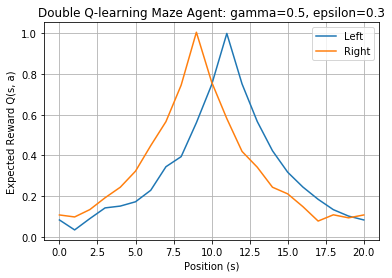

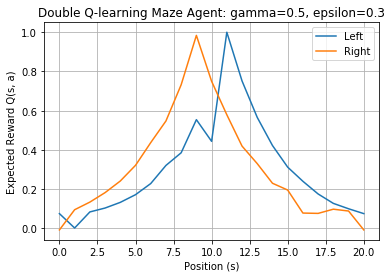

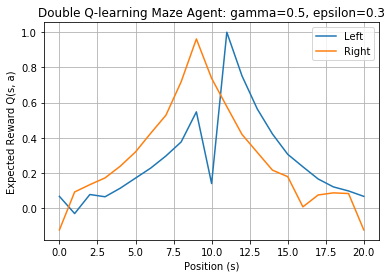

In [63]:
for data in plots:
    plot(f"Double Q-learning Maze Agent: gamma={data[0]}, epsilon={data[1]}", MAZE_SIZE, data[2:], ("Left", "Right"))

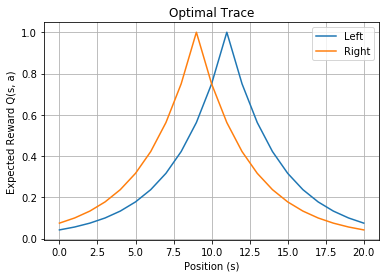

In [24]:
optimalLeft = [DISCOUNT**abs((GOAL + 1) - i) for i in range(MAZE_SIZE+1)]
optimalRight = [DISCOUNT**abs((GOAL - 1) - i) for i in range(MAZE_SIZE+1)]
plot(f"Optimal Trace", MAZE_SIZE, (optimalLeft, optimalRight), ("Left", "Right"))

In [34]:
results = []

for (_, _, l, r) in plots:
    maxDiff = 0
    totalDiff = 0
    for i in range(MAZE_SIZE):
        diff = abs(l[i] - optimalLeft[i]) + abs(r[i] - optimalRight[i])
        totalDiff += diff
        maxDiff = max(maxDiff, diff)
    results.append((maxDiff, totalDiff/MAZE_SIZE))
    
minDiffIndex = 0
minDiff = results[0][1][0]
minAvgIndex = 0
minAvg = results[0][0][0]
for i, result in enumerate(results[1:]):
    if result[0][0] < minAvg:
        minAvgIndex = i+1
        minAvg = result[0][0]
    if result[1][0] < minDiff:
        minDiffIndex = i+1
        minDiff = result[1][0]
    
print(minDiffIndex)
print(minDiff)
print()
print(minAvgIndex)
print(minAvg)

29
0.0065562995

34
0.08576436
